In [1]:
import pickle as pkl
import logging
import numpy as np
from scipy import linalg
import pandas as pd
import mne
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC, SVC
from pyriemann.estimation import Covariances
from pyriemann.spatialfilters import CSP
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import TSclassifier, MDM, FgMDM, KNearestNeighbor
from collections import defaultdict
from tqdm import tqdm

from alignment import *

logging.getLogger("mne").setLevel(logging.ERROR)

In [2]:
X = list()
meta = list()
for file_ext in ["1_40", "41_80", "81_109"]:
    with open(f"../data/beetl/phy_vin_{file_ext}.pkl", mode="rb") as f:
        x, labels, m = pkl.load(f)["data"]
        m["label"] = labels
        m = m[
            (~m["subject"].isin([88, 92, 100, 104]))
            & (m["run"].isin([f"run_{d}" for d in range(4, 15, 2)]))
            & (m["label"] != "rest")
        ]  # imagined runs only
        x = x[m.index]
        m = m.reset_index(drop=True)
        X.append(x)
        meta.append(m)

X = np.concatenate(X, axis=0)
meta = pd.concat(meta)

le = LabelEncoder()
meta["label"] = le.fit_transform(meta["label"])
print(le.classes_)

print(X.shape)
meta

['feet' 'hands' 'left_hand' 'right_hand']
(9450, 28, 385)


,subject,session,run,label
0,1,session_0,run_4,3
1,1,session_0,run_4,2
2,1,session_0,run_4,2
3,1,session_0,run_4,3
4,1,session_0,run_4,3
...,...,...,...,...
2245,109,session_0,run_14,0
2246,109,session_0,run_14,1
2247,109,session_0,run_14,1
2248,109,session_0,run_14,0


In [13]:
tgt_subject = 1

tgt_meta = meta[meta["subject"] == tgt_subject]
Xtgt = X[tgt_meta.index]
Ytgt = np.array(tgt_meta["label"], dtype=int)

Xtgt.shape

(90, 28, 385)

<AxesSubplot:>

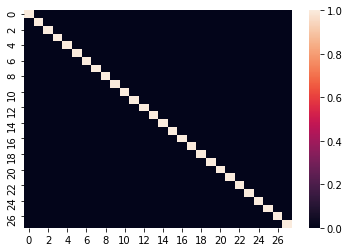

In [14]:
x = euclidean_alignment(Xtgt)
# x = compute_transform_mat(Xtgt, use_log=True) @ Xtgt
sb.heatmap(np.mean(x @ x.transpose((0, 2, 1)), axis=0))

In [15]:
tgtRs = compute_target_transform_mats(Xtgt, Ytgt)
len(tgtRs)

4

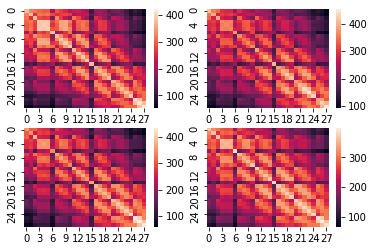

In [17]:
fig, axes = plt.subplots(2, 2)
for i in range(4):
    x = Xtgt[np.where(Ytgt == i)[0]]
    sb.heatmap(np.mean(x @ x.transpose((0, 2, 1)), axis=0), ax=axes[i // 2, i % 2])

In [16]:
src_subject = 2

src_meta = meta[meta["subject"] == src_subject]
Xsrc = X[src_meta.index]
Ysrc = np.array(src_meta["label"], dtype=int)

Xsrc.shape

(90, 28, 385)

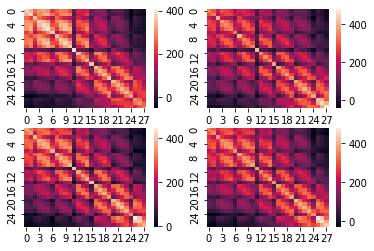

In [18]:
fig, axes = plt.subplots(2, 2)
for i in range(4):
    x = Xsrc[np.where(Ysrc == i)[0]]
    sb.heatmap(np.mean(x @ x.transpose((0, 2, 1)), axis=0), ax=axes[i // 2, i % 2])

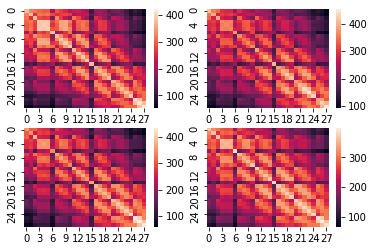

In [19]:
_Xsrc = label_alignment(Xsrc, Ysrc, tgtRs)

fig, axes = plt.subplots(2, 2)
for i in range(4):
    x = _Xsrc[np.where(Ysrc == i)[0]]
    sb.heatmap(np.mean(x @ x.transpose((0, 2, 1)), axis=0), ax=axes[i // 2, i % 2])

In [13]:
# data alignment pipeline
# - align src's label dist to tgt's (run_4, run_6) label dist
# - align src's input dist
# - align tgt's (run_4, run_6) input dist

In [72]:
def compute_reference_mat(x, inv=True):
    # x: [bsz, ch, t]
    r = np.mean(x @ x.transpose((0, 2, 1)), axis=0)  # [ch,ch]
    r = linalg.inv(linalg.sqrtm(r)) if inv else linalg.sqrtm(r)
    if np.iscomplexobj(r):
        r = np.real(r).astype(np.float32)

    return r

In [108]:
target_subject = 109
target_meta = meta[meta["subject"] == target_subject]
train_target_meta = target_meta[
    target_meta["run"].isin([f"run_{i}" for i in range(4, 7, 2)])
]
valid_target_meta = target_meta[
    target_meta["run"].isin([f"run_{i}" for i in range(8, 15, 2)])
]
Xtarget_train = X[train_target_meta.index]
Ytarget_train = np.array(train_target_meta["label"], dtype=int)
Xtarget_valid = X[valid_target_meta.index]
Ytarget_valid = np.array(valid_target_meta["label"], dtype=int)

print(
    f"target_subject: {target_subject} - train: {Xtarget_train.shape}/{np.bincount(Ytarget_train)} - valid: {Xtarget_valid.shape}/{np.bincount(Ytarget_valid)}"
)

target_subject: 109 - train: (30, 28, 385)/[7 8 7 8] - valid: (60, 28, 385)/[15 15 16 14]


<AxesSubplot:>

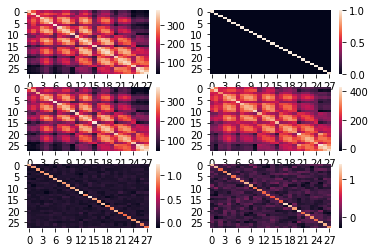

In [109]:
fig, axes = plt.subplots(3, 2)

r = compute_reference_mat(Xtarget_train)[np.newaxis]

x = Xtarget_train
sb.heatmap(np.mean(x @ x.transpose((0, 2, 1)), axis=0), ax=axes[0, 0])

x = r @ Xtarget_train
sb.heatmap(np.mean(x @ x.transpose((0, 2, 1)), axis=0), ax=axes[0, 1])

x = Xtarget_train[np.where(Ytarget_train == 0)[0]]
x0 = x[0]
sb.heatmap(np.mean(x @ x.transpose((0, 2, 1)), axis=0), ax=axes[1, 0])
sb.heatmap(x0 @ x0.transpose((1, 0)), ax=axes[1, 1])

x = r @ x
x0 = r[0] @ x0
sb.heatmap(np.mean(x @ x.transpose((0, 2, 1)), axis=0), ax=axes[2, 0])
sb.heatmap(x0 @ x0.transpose((1, 0)), ax=axes[2, 1])

In [98]:
target_class_ref = dict()
for i in range(len(le.classes_)):
    class_idx = np.where(Ytarget_train == i)[0]
    target_class_ref[i] = compute_reference_mat(Xtarget_train[class_idx], inv=False)[
        np.newaxis
    ]

<AxesSubplot:>

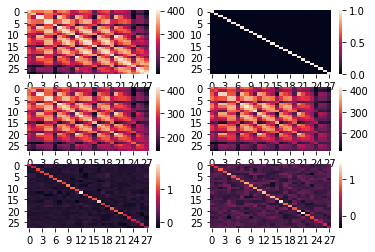

In [99]:
meta_tmp = meta[meta["subject"] == 2]
Xtmp = X[meta_tmp.index]
Ytmp = np.array(meta_tmp["label"], dtype=int)

for i in range(len(le.classes_)):
    class_idx = np.where(Ytmp == i)[0]
    Xtmp[class_idx] = (
        target_class_ref[i]
        @ compute_reference_mat(Xtmp[class_idx])[np.newaxis]
        @ Xtmp[class_idx]
    )

fig, axes = plt.subplots(3, 2)

r = compute_reference_mat(Xtmp)[np.newaxis]

x = Xtmp
sb.heatmap(np.mean(x @ x.transpose((0, 2, 1)), axis=0), ax=axes[0, 0])

x = r @ Xtmp
sb.heatmap(np.mean(x @ x.transpose((0, 2, 1)), axis=0), ax=axes[0, 1])

x = Xtmp[np.where(Ytmp == 0)[0]]
x0 = x[0]
sb.heatmap(np.mean(x @ x.transpose((0, 2, 1)), axis=0), ax=axes[1, 0])
sb.heatmap(x0 @ x0.transpose((1, 0)), ax=axes[1, 1])

x = r @ x
x0 = r[0] @ x0
sb.heatmap(np.mean(x @ x.transpose((0, 2, 1)), axis=0), ax=axes[2, 0])
sb.heatmap(x0 @ x0.transpose((1, 0)), ax=axes[2, 1])

In [118]:
%%time
# clf = make_pipeline(
#     Covariances("sch"),
#     TSclassifier(
#         metric="riemann",
#         clf=SVC(
#             C=1.0,
#             kernel="rbf",
#             tol=1e-7,
#             max_iter=30000,
#             class_weight="balanced",
#             random_state=42,
#         ),
#     ),
#     FgMDM(metric=dict(mean="logeuclid", distance="riemann"), n_jobs=-1),
# )
clf = make_pipeline(
    mne.decoding.CSP(n_components=16, reg="shrunk", log=True, cov_est="epoch"),
    SVC(
        C=1.0,
        kernel="rbf",
        tol=1e-7,
        max_iter=30000,
        class_weight="balanced",
        random_state=42,
    ),
)

clf.fit(Xtarget_train, Ytarget_train)

pred = clf.predict(Xtarget_valid)
print(classification_report(Ytarget_valid, pred))
print(confusion_matrix(Ytarget_valid, pred))
print(f"accuracy: {balanced_accuracy_score(Ytarget_valid, pred)}")

              precision    recall  f1-score   support

           0       0.62      0.53      0.57        15
           1       0.17      0.27      0.21        15
           2       0.20      0.06      0.10        16
           3       0.32      0.43      0.36        14

    accuracy                           0.32        60
   macro avg       0.33      0.32      0.31        60
weighted avg       0.32      0.32      0.31        60

[[8 3 2 2]
 [3 4 1 7]
 [2 9 1 4]
 [0 7 1 6]]
accuracy: 0.32276785714285716
CPU times: user 11.5 s, sys: 15.5 s, total: 26.9 s
Wall time: 7.53 s


/home/txdat/miniconda3/lib/python3.9/site-packages/mne/decoding/csp.py:184: DeprecationWarning: scipy.linalg.pinv2 is deprecated since SciPy 1.7.0, use scipy.linalg.pinv instead
  self.patterns_ = linalg.pinv2(eigen_vectors)


In [119]:
%%time
Xtrain = list()
Ytrain = list()

# compute target's class' mean covariance
target_class_ref = dict()
for i in range(len(le.classes_)):
    class_idx = np.where(Ytarget_train == i)[0]
    target_class_ref[i] = compute_reference_mat(Xtarget_train[class_idx], inv=False)[
        np.newaxis
    ]

Rtarget = compute_reference_mat(np.concatenate((Xtarget_train, Xtarget_valid), axis=0))[
    np.newaxis
]

Xtrain.append(Rtarget @ Xtarget_train)  # euclidean alignment
Ytrain.append(Ytarget_train)
# Xtrain.append(Xtarget_train)
# Ytrain.append(Ytarget_train)

for aux_subject in tqdm(sorted(meta["subject"].unique()), desc="subject"):
    if aux_subject == target_subject:
        continue

    aux_meta = meta[meta["subject"] == aux_subject]
    Xaux = X[aux_meta.index]
    Yaux = np.array(aux_meta["label"], dtype=int)

    # label alignment
    for i in range(len(le.classes_)):
        class_idx = np.where(Yaux == i)[0]
        Xaux[class_idx] = (
            target_class_ref[i]
            @ compute_reference_mat(Xaux[class_idx])[np.newaxis]
            @ Xaux[class_idx]
        )

    Xtrain.append(compute_reference_mat(Xaux)[np.newaxis] @ Xaux)  # euclidean alignment
    Ytrain.append(Yaux)
#     Xtrain.append(Xaux)
#     Ytrain.append(Yaux)

Xtrain = np.concatenate(Xtrain, axis=0)
Ytrain = np.concatenate(Ytrain, axis=0)
Xvalid = Rtarget @ Xtarget_valid  # euclidean alignment
Yvalid = Ytarget_valid
# Xvalid = Xtarget_valid
# Yvalid = Ytarget_valid

print(
    f"train: {Xtrain.shape}/{np.bincount(Ytrain)} - valid: {Xvalid.shape}/{np.bincount(Yvalid)}"
)

subject: 100%|██████████████████████████████████████████████████| 105/105 [00:10<00:00, 10.05it/s]


train: (9390, 28, 385)/[2344 2351 2368 2327] - valid: (60, 28, 385)/[15 15 16 14]
CPU times: user 15.2 s, sys: 18.5 s, total: 33.7 s
Wall time: 11.1 s


In [120]:
%%time
# clf = make_pipeline(
#     Covariances("sch"),
#     TSclassifier(
#         metric="riemann",
#         clf=SVC(
#             C=1.0,
#             kernel="rbf",
#             tol=1e-7,
#             max_iter=30000,
#             class_weight="balanced",
#             random_state=42,
#         ),
#     ),
# #     FgMDM(metric=dict(mean="logeuclid", distance="riemann"), n_jobs=-1),
# )
clf = make_pipeline(
    mne.decoding.CSP(n_components=16, reg="shrunk", log=True, cov_est="epoch"),
    SVC(
        C=1.0,
        kernel="rbf",
        tol=1e-7,
        max_iter=30000,
        class_weight="balanced",
        random_state=42,
    ),
)

clf.fit(Xtrain, Ytrain)

pred = clf.predict(Xvalid)
print(classification_report(Yvalid, pred))
print(confusion_matrix(Yvalid, pred))
print(f"accuracy: {balanced_accuracy_score(Yvalid, pred)}")

/home/txdat/miniconda3/lib/python3.9/site-packages/mne/decoding/csp.py:184: DeprecationWarning: scipy.linalg.pinv2 is deprecated since SciPy 1.7.0, use scipy.linalg.pinv instead
  self.patterns_ = linalg.pinv2(eigen_vectors)


              precision    recall  f1-score   support

           0       0.50      0.33      0.40        15
           1       0.28      0.53      0.36        15
           2       0.20      0.06      0.10        16
           3       0.25      0.29      0.27        14

    accuracy                           0.30        60
   macro avg       0.31      0.30      0.28        60
weighted avg       0.31      0.30      0.28        60

[[5 8 0 2]
 [1 8 1 5]
 [3 7 1 5]
 [1 6 3 4]]
accuracy: 0.30372023809523807
CPU times: user 56min 41s, sys: 1h 22min 12s, total: 2h 18min 54s
Wall time: 37min 8s
